In [1]:
from dataclasses import dataclass

import torch
from torch.utils.data import DataLoader

from dviforbml.architectures.dvi import DVI
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.dis import DIS
from dviforbml.components.cdvi.ula import ULA
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.encoder.proj_encoder import ProjEncoder
from dviforbml.components.schedule.annealing_schedule import AnnealingSchedule
from dviforbml.components.schedule.constr_noise_schedule import ConstrNoiseSchedule
from dviforbml.components.schedule.free_noise_schedule import FreeNoiseSchedule
from dviforbml.components.schedule.step_size_schedule import StepSizeSchedule
from dviforbml.evaluation.visualization.visualize_dvi import visualize_dvi_1d
from dviforbml.training.dvi_trainer import DVITrainerContext
from dviforbml.utils.datasets import ContextTestDataset
from dviforbml.utils.distros import ContextualGMM

In [2]:
device = torch.device("cpu")

In [3]:
@dataclass
class Config:
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "ReLU"
    use_score = False
    learning_rate = 3e-3
    size = 64
    batch_size = 64


config = Config()

In [4]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
contextual_target = lambda context, _: ContextualGMM(
    context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7)
)

encoder = ProjEncoder(c_dim=config.c_dim, h_dim=config.h_dim)

control = AggrControl(
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    max_context_size=None,
    use_score=config.use_score,
)

noise_schedule = FreeNoiseSchedule(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    device=device,
)

step_size_schedule = StepSizeSchedule(num_steps=config.num_steps, device=device)

annealing_schedule = AnnealingSchedule(num_steps=config.num_steps, device=device)

cdvi = DIS(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    control=control,
    step_size_schedule=step_size_schedule,
    noise_schedule=noise_schedule,
    annealing_schedule=annealing_schedule,
    use_score=config.use_score,
    device=device,
)

# cdvi = CMCD(
#     z_dim=config.z_dim,
#     num_steps=config.num_steps,
#     control=control,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device,
# )

# cdvi = ULA(
#     z_dim=config.z_dim,
#     num_steps=config.num_steps,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device,
# )

model = DVI(encoder=encoder, cdvi=cdvi, contextual_target=contextual_target).to(device)

In [6]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(),
    wandb_logging=False,
    num_subtasks=1,
    num_samples=1,
    val_grad_off=True,
)

print(model)

DVI(
  (encoder): ProjEncoder(
    (proj_c): Linear(in_features=1, out_features=32, bias=True)
  )
  (cdvi): DIS(
    (control): AggrControl(
      (proj_n): Embedding(17, 1)
      (mlp): Sequential(
        (0): Linear(in_features=34, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=32, bias=True)
        (5): ReLU()
        (6): Linear(in_features=32, out_features=32, bias=True)
        (7): ReLU()
      )
      (proj_out): Linear(in_features=32, out_features=1, bias=True)
    )
    (step_size_schedule): StepSizeSchedule()
    (noise_schedule): FreeNoiseSchedule()
    (annealing_schedule): AnnealingSchedule()
  )
)


In [11]:
train = True

if train:
    num_epochs = 1000
    trainer.train(num_epochs=num_epochs, max_clip_norm=None, alpha=None)

100%|██████████| 1/1 [00:00<00:00, 52.97it/s, epoch=999, loss=0.512]


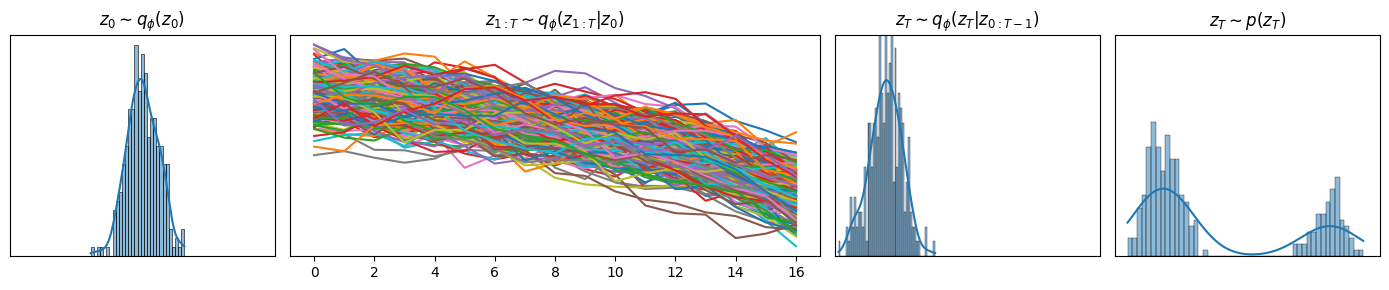

In [13]:
visualize_dvi_1d(device, model, dataset, num_samples=256)